The implementation based on the paper, **Learning Combinatorial Optimization Algorithms over Graphs** by Dai, Hanjun and Khalil, Elias B and Zhang, Yuyu and Dilkina, Bistra and Song, Le, modified and simplified from the version of Louis Veillon.

Let's start with installing, importing pakages and configuration.

In [4]:
!pip install pulp

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random
import networkx as nx
import time
import os
import yaml
import pulp
import collections
import sys

In [0]:
def load_config():
    with open("config.yml") as config:
        model_config = yaml.load(config)
    return model_config

Define types of degree distribution: **erdos_renyi**, **powerlaw**, **barabasi_albert** and **gnp_random_graph**, objects of graphs and some methods.

In [0]:
class Graph:
    def __init__(self, graph_type, cur_n, p, m=None, seed=None):
        if graph_type == 'erdos_renyi':
            self.g = nx.erdos_renyi_graph(n=cur_n, p=p, seed=seed)
        elif graph_type == 'powerlaw':
            self.g = nx.powerlaw_cluster_graph(n=cur_n, m=m, p=p, seed=seed)
        elif graph_type == 'barabasi_albert':
            self.g = nx.barabasi_albert_graph(n=cur_n, m=m, seed=seed)
        elif graph_type =='gnp_random_graph':
            self.g = nx.gnp_random_graph(n=cur_n, p=p, seed=seed)

    def nodes(self):
        return nx.number_of_nodes(self.g)

    def edges(self):
        return self.g.edges()

    def neighbors(self, node):
        return nx.all_neighbors(self.g,node)

    def average_neighbor_degree(self, node):
        return nx.average_neighbor_degree(self.g, nodes=node)

    def adj(self):
        return nx.adjacency_matrix(self.g)

Define the algorithms:

* **S2V** for structure2vec
* **GCN** for graph convolutional network



In [0]:
class S2V(torch.nn.Module):
    def __init__(self,hidden_reg, embed_dim, pre_pool_len, post_pool_len, T):
        super(S2V, self).__init__()
        self.T = T
        self.embed_dim=embed_dim
        self.hidden_reg=hidden_reg
        self.pre_pool_len = pre_pool_len
        self.post_pool_len = post_pool_len
        self.mu_1 = torch.nn.Parameter(torch.Tensor(1, embed_dim))
        torch.nn.init.normal_(self.mu_1, mean=0, std=0.01)
        self.mu_2 = torch.nn.Linear(embed_dim, embed_dim,True)
        torch.nn.init.normal_(self.mu_2.weight, mean=0, std=0.01)
        self.list_pre_pool = []
        for k in range(self.pre_pool_len):
            linear = torch.nn.Linear(embed_dim,embed_dim,bias=True)
            torch.nn.init.normal_(linear.weight, mean=0, std=0.01)
            self.list_pre_pool.append(linear)
        self.list_post_pool = []
        for k in range(self.post_pool_len):
            linear =torch.nn.Linear(embed_dim,embed_dim,bias=True)
            torch.nn.init.normal_(linear.weight, mean=0, std=0.01)
            self.list_post_pool.append(linear)
        self.q_1 = torch.nn.Linear(embed_dim, embed_dim,bias=True)
        torch.nn.init.normal_(self.q_1.weight, mean=0, std=0.01)
        self.q_2 = torch.nn.Linear(embed_dim, embed_dim,bias=True)
        torch.nn.init.normal_(self.q_2.weight, mean=0, std=0.01)
        if self.hidden_reg > 0:
            self.q_reg = torch.nn.Linear(2 * embed_dim, self.hidden_reg)
            torch.nn.init.normal_(self.q_reg.weight, mean=0, std=0.01)
            self.q = torch.nn.Linear(self.hidden_reg, 1)
        else:
            self.q = torch.nn.Linear(2 * embed_dim, 1)
        torch.nn.init.normal_(self.q.weight, mean=0, std=0.01)

    def forward(self, vex, adjacent):
        minibatch_size = vex.shape[0]
        nbr_node = vex.shape[1]

        for t in range(self.T):
            if t == 0:
                mu = torch.matmul(vex, self.mu_1).clamp(0)
            else:
                mu_1 = torch.matmul(vex, self.mu_1).clamp(0)
                for k in range(self.pre_pool_len):
                    mu = self.list_pre_pool[k](mu).clamp(0)

                mu_pool = torch.matmul(adjacent, mu)
                for k in range(self.post_pool_len):
                    mu_pool = self.list_post_pool[k](mu_pool).clamp(0)

                mu_2 = self.mu_2(mu_pool)
                mu = torch.add(mu_1, mu_2).clamp(0)
        q_1 = self.q_1(torch.matmul(vex.transpose(1,2),mu)).expand(minibatch_size,nbr_node,self.embed_dim)
        q_2 = self.q_2(mu)
        q_ = torch.cat((q_1, q_2), dim=-1)
        if self.hidden_reg > 0:
            q_reg = self.q_reg(q_).clamp(0)
            q = self.q(q_reg)
        else:
            q_=q_.clamp(0)
            q = self.q(q_)
        return q

class GCN(torch.nn.Module):
    def __init__(self,hidden_reg, embed_dim, pre_pool_len, post_pool_len, T):
        super(GCN, self).__init__()
        self.hidden_reg =hidden_reg
        self.embed_dim = embed_dim
        self.T = T
        self.pre_pool_len = pre_pool_len
        self.post_pool_len = post_pool_len
        self.mu_1 = torch.nn.Parameter(torch.Tensor(1, embed_dim))
        torch.nn.init.normal_(self.mu_1, mean=0, std=0.01)
        self.mu_2 = torch.nn.Linear(embed_dim, embed_dim, True)
        torch.nn.init.normal_(self.mu_2.weight, mean=0, std=0.01)
        self.list_pre_pool = []
        for k in range(self.pre_pool_len):
            linear = torch.nn.Linear(embed_dim, embed_dim, bias=True)
            torch.nn.init.normal_(linear.weight, mean=0, std=0.01)
            self.list_pre_pool.append(linear)
        self.list_post_pool = []
        for k in range(self.post_pool_len):
            linear = torch.nn.Linear(embed_dim, embed_dim, bias=True)
            torch.nn.init.normal_(linear.weight, mean=0, std=0.01)
            self.list_post_pool.append(linear)
        self.q_1 = torch.nn.Linear(embed_dim, embed_dim,bias=True)
        torch.nn.init.normal_(self.q_1.weight, mean=0, std=0.01)
        self.q_2 = torch.nn.Linear(embed_dim, embed_dim,bias=True)
        torch.nn.init.normal_(self.q_2.weight, mean=0, std=0.01)
        self.q = torch.nn.Linear(2 * embed_dim, 1,bias=True)
        if self.hidden_reg > 0:
            self.q_reg = torch.nn.Linear(2 * embed_dim, self.hidden_reg)
            torch.nn.init.normal_(self.q_reg.weight, mean=0, std=0.01)
            self.q = torch.nn.Linear(self.hidden_reg, 1)
        else:
            self.q = torch.nn.Linear(2 * embed_dim, 1)
        torch.nn.init.normal_(self.q.weight, mean=0, std=0.01)

    def forward(self, vex, adjacent):
        minibatch_size = vex.shape[0]
        nbr_node = vex.shape[1]
        diag = torch.ones(nbr_node)
        x = torch.diag(diag).expand(minibatch_size,nbr_node,nbr_node)
        adj_=adjacent+x
        D = torch.sum(adjacent,dim=1)
        zero_selec = np.where(D.detach().numpy() == 0)
        D[zero_selec[0], zero_selec[1]] = 0.01
        d = []
        for vec in D:
            d.append(torch.diag(vec))
        d=torch.stack(d)
        gv=torch.matmul(torch.inverse(d),adj_)
        for t in range(self.T):
            if t == 0:
                mu = torch.matmul(vex, self.mu_1).clamp(0)
            else:
                mu_1 = torch.matmul(vex, self.mu_1).clamp(0)
                for k in range(self.pre_pool_len):
                    mu = self.list_pre_pool[k](mu).clamp(0)
                mu_pool = torch.matmul(gv, mu)
                for k in range(self.post_pool_len):
                    mu_pool = self.list_post_pool[k](mu_pool).clamp(0)
                mu_2 = self.mu_2(mu_pool)
                mu = torch.add(mu_1, mu_2).clamp(0)
        q_1 = self.q_1(torch.matmul(vex.transpose(1,2),mu)).expand(minibatch_size,nbr_node,self.embed_dim)
        q_2 = self.q_2(mu)
        q_ = torch.cat((q_1, q_2), dim=-1)
        if self.hidden_reg > 0:
            q_reg = self.q_reg(q_).clamp(0)
            q = self.q(q_reg)
        else:
            q_=q_.clamp(0)
            q = self.q(q_)
        return q

Define the environment objects:

* **MVC** for Minimum vertex cover
* **MAXCUT** for Maximum cut set

and the method to obtain the optimal solution.

Here are some importants functions:

* **observe** for obtaining states features of the problem
* **get_reward** for obtaining the *reward* and *done* that is the information from the last action.





In [0]:
class Environment:
    def __init__(self, graph,name):
        self.graphs = graph
        self.name= name

    def env_reset(self, g):
        self.games = g
        self.graph_init = self.graphs[self.games]
        self.nodes = self.graph_init.nodes()
        self.nbr_of_nodes = 0
        self.edge_add_old = 0
        self.last_reward = 0
        self.observation = torch.zeros(1,self.nodes,1,dtype=torch.float)

    def observe(self):
        return self.observation

    def act(self,node):
        self.observation[:,node,:]=1
        reward = self.get_reward(self.observation, node)
        return reward

    def get_reward(self, observation, node):
        if self.name == "MVC":
            new_nbr_nodes=np.sum(observation[0].numpy())
            if new_nbr_nodes - self.nbr_of_nodes > 0:
                reward = -1
            else:
                reward = 0
            self.nbr_of_nodes=new_nbr_nodes
            done = True
            edge_add = 0
            for edge in self.graph_init.edges():
                if observation[:,edge[0],:]==0 and observation[:,edge[1],:]==0:
                    done=False
                else:
                    edge_add += 1
            self.edge_add_old = edge_add
            return (reward,done)

        elif self.name=="MAXCUT" :
            reward=0
            done=False
            adj= self.graph_init.edges()
            select_node=np.where(self.observation[0, :, 0].numpy() == 1)[0]
            for nodes in adj:
                if ((nodes[0] in select_node) & (nodes[1] not in select_node)) | ((nodes[0] not in select_node) & (nodes[1] in select_node))  :
                    reward += 1
            change_reward = reward-self.last_reward
            if change_reward<=0:
                done=True
            self.last_reward = reward
            return (change_reward,done)

    def get_optimal_sol(self):
        if self.name =="MVC":
            x = list(range(self.graph_init.g.number_of_nodes()))
            xv = pulp.LpVariable.dicts('is_opti', x,
                                       lowBound=0,
                                       upBound=1,
                                       cat=pulp.LpInteger)
            mdl = pulp.LpProblem("MVC", pulp.LpMinimize)
            mdl += sum(xv[k] for k in xv)
            for edge in self.graph_init.edges():
                mdl += xv[edge[0]] + xv[edge[1]] >= 1, "constraint :" + str(edge)
            mdl.solve()
            optimal=0
            for x in xv:
                optimal += xv[x].value()
            return optimal

        elif self.name=="MAXCUT":
            x = list(range(self.graph_init.g.number_of_nodes()))
            e = list(self.graph_init.edges())
            xv = pulp.LpVariable.dicts('is_opti', x,
                                       lowBound=0,
                                       upBound=1,
                                       cat=pulp.LpInteger)
            ev = pulp.LpVariable.dicts('ev', e,
                                       lowBound=0,
                                       upBound=1,
                                       cat=pulp.LpInteger)

            mdl = pulp.LpProblem("MVC", pulp.LpMaximize)
            mdl += sum(ev[k] for k in ev)
            for i in e:
                mdl+= ev[i] <= xv[i[0]]+xv[i[1]]
            for i in e:
                mdl+= ev[i]<= 2 -(xv[i[0]]+xv[i[1]])
            mdl.solve()
            return mdl.objective.value()

Define agent objects and methods that are necessary for the algorithms.

Here are some importants functions:

* **act** for taking an action from the last observation
* **f_reward** will be used in the next step.

In [0]:
class Agent:
    def __init__(self,graph,model,lr,bs,n_step):
        self.graphs = graph
        self.embed_dim = 64
        self.model_name = model
        self.k = 20
        self.alpha = 0.1
        self.gamma = 0.99
        self.lambd = 0.
        self.n_step=n_step
        self.epsilon_=1
        self.epsilon_min=0.02
        self.discount_factor =0.999990
        self.t=1
        self.memory = []
        self.memory_n=[]
        self.minibatch_length = bs

        if self.model_name == 'S2V':
            args_init = load_config()[self.model_name]
            self.model = S2V(**args_init)
        elif self.model_name== 'GCN':
            args_init = load_config()[self.model_name]
            self.model = GCN(**args_init)
        self.criterion = torch.nn.MSELoss(reduction='sum')
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.T = 5
        self.t = 1

    def agent_reset(self, g):
        self.games = g
        if (len(self.memory_n) != 0) and (len(self.memory_n) % 300000 == 0):
            self.memory_n =random.sample(self.memory_n,120000)
        self.nodes = self.graphs[self.games].nodes()
        self.adj = self.graphs[self.games].adj()
        self.adj = self.adj.todense()
        self.adj = torch.from_numpy(np.expand_dims(self.adj.astype(int), axis=0))
        self.adj = self.adj.type(torch.FloatTensor)
        self.last_action = 0
        self.last_observation = torch.zeros(1, self.nodes, 1, dtype=torch.float)
        self.last_reward = -0.01
        self.last_done=0
        self.iter=1

    def act(self, observation):
        if self.epsilon_ > np.random.rand():
            return np.random.choice(np.where(observation.numpy()[0,:,0] == 0)[0])
        else:
            q_a = self.model(observation, self.adj)
            q_a=q_a.detach().numpy()
            return np.where((q_a[0, :, 0] == np.max(q_a[0, :, 0][observation.numpy()[0, :, 0] == 0])))[0][0]

    def f_reward(self, observation, action, reward,done):
        if len(self.memory_n) > self.minibatch_length + self.n_step:
            (last_observation_tens, action_tens, reward_tens, observation_tens, done_tens,adj_tens) = self.get_sample()
            target = reward_tens + self.gamma *(1-done_tens)*torch.max(self.model(observation_tens, adj_tens) + observation_tens * (-1e5), dim=1)[0]
            target_f = self.model(last_observation_tens, adj_tens)
            target_p = target_f.clone()
            target_f[range(self.minibatch_length),action_tens,:] = target
            loss=self.criterion(target_p, target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if self.epsilon_ > self.epsilon_min:
               self.epsilon_ *= self.discount_factor
        if self.iter>1:
            self.remember(self.last_observation, self.last_action, self.last_reward, observation.clone(),self.last_done*1)
        if done & self.iter> self.n_step:
              self.remember_n(False)
              new_observation = observation.clone()
              new_observation[:,action,:]=1
              self.remember(observation,action,reward,new_observation,done*1)
        if self.iter > self.n_step:
            self.remember_n(done)
        self.iter+=1
        self.t += 1
        self.last_action = action
        self.last_observation = observation.clone()
        self.last_reward = reward
        self.last_done = done

    def get_sample(self):
        minibatch = random.sample(self.memory_n, self.minibatch_length - 1)
        minibatch.append(self.memory_n[-1])
        last_observation_tens = minibatch[0][0]
        action_tens = torch.Tensor([minibatch[0][1]]).type(torch.LongTensor)
        reward_tens = torch.Tensor([[minibatch[0][2]]])
        observation_tens = minibatch[0][3]
        done_tens =torch.Tensor([[minibatch[0][4]]])
        adj_tens = self.graphs[minibatch[0][5]].adj().todense()
        adj_tens = torch.from_numpy(np.expand_dims(adj_tens.astype(int), axis=0)).type(torch.FloatTensor)
        for last_observation_, action_, reward_, observation_, done_, games_ in minibatch[-self.minibatch_length + 1:]:
            last_observation_tens=torch.cat((last_observation_tens,last_observation_))
            action_tens = torch.cat((action_tens, torch.Tensor([action_]).type(torch.LongTensor)))
            reward_tens = torch.cat((reward_tens, torch.Tensor([[reward_]])))
            observation_tens = torch.cat((observation_tens, observation_))
            done_tens = torch.cat((done_tens,torch.Tensor([[done_]])))
            adj_ = self.graphs[games_].adj().todense()
            adj = torch.from_numpy(np.expand_dims(adj_.astype(int), axis=0)).type(torch.FloatTensor)
            adj_tens = torch.cat((adj_tens, adj))
        return (last_observation_tens, action_tens, reward_tens, observation_tens,done_tens, adj_tens)

    def remember(self, last_observation, last_action, last_reward, observation,done):
        self.memory.append((last_observation, last_action, last_reward, observation,done, self.games))

    def remember_n(self,done):
        if not done:
            step_init = self.memory[-self.n_step]
            cum_reward=step_init[2]
            for step in range(1,self.n_step):
                cum_reward+=self.memory[-step][2]
            self.memory_n.append((step_init[0], step_init[1], cum_reward, self.memory[-1][-3],self.memory[-1][-2], self.memory[-1][-1]))
        else:
            for i in range(1,self.n_step):
                step_init = self.memory[-self.n_step+i]
                cum_reward=step_init[2]
                for step in range(1,self.n_step-i):
                    cum_reward+=self.memory[-step][2]
                if i==self.n_step-1:
                    self.memory_n.append(
                        (step_init[0], step_init[1], cum_reward, self.memory[-1][-3], False, self.memory[-1][-1]))
                else:
                    self.memory_n.append((step_init[0], step_init[1], cum_reward,self.memory[-1][-3], False, self.memory[-1][-1]))

Each step of the reinforcement learning, **Q-learning**, will be called in this part.

In [0]:
class Runner:
    def __init__(self, environment, agent, verbose=False):
        self.environment = environment
        self.agent = agent
        self.verbose = verbose

    def step(self):
        observation = self.environment.observe().clone()
        action = self.agent.act(observation).copy()
        (reward, done) = self.environment.act(action)
        self.agent.f_reward(observation, action, reward,done)
        return (observation, action, reward, done)

    def loop(self, games,nbr_epoch, max_iter):
        cumul_reward = 0.0
        list_cumul_reward=[]
        list_optimal_ratio = []
        list_aprox_ratio =[]
        for epoch_ in range(nbr_epoch):
            print("Epoch: "+str(epoch_))
            for g in range(1, games + 1):
                print("Game number: "+str(g))
                for epoch in range(5):
                    self.environment.env_reset(g)
                    self.agent.agent_reset(g)
                    cumul_reward = 0.0
                    for i in range(1, max_iter + 1):
                        (obs, act, rew, done) = self.step()
                        cumul_reward += rew
                        if self.verbose:
                            if done:
                                optimal_sol = self.environment.get_optimal_sol()
                                print("    Cumulative rewards = {}".format(cumul_reward))
                                print("    Optimal solution = {}".format(optimal_sol))
                                list_cumul_reward.append(-cumul_reward)
                        if done:
                            break
            if self.verbose:
                print("Finished game number: {}".format(g))
                print("")
        plt.plot(list_cumul_reward)
        plt.xlabel("Time")
        plt.ylabel("Cumulative reward")
        plt.show()
        return cumul_reward

Finally, we will launch the code with function **main** with arguments:

* **environment_name** is the type of optimization problems: **MVC** or **MAXCUT**.
* **agent** is the name of the agent.
* **graph_type** is the type of degree distribution of graphs: **erdos_renyi**, **powerlaw**, **barabasi_albert** or **gnp_random_graph**.
* **graph_nbr** is the number of different graphs in training sample.
* **model** is the name of model: **S2V** or **GCN**.
* **ngames** is the number of games to simulate per epochs (5 times per each game).
* **niter** is the max number of iterations per game if the algorithm does not reach the terminal step.
* **epoch** is the number of epochs.
* **lr** is the learning rate.
* **bs** is the size of minibatch for training.
* **n_step** is the number of steps in Reinforcement Learning.
* **node** is the number of nodes in graphs.
* **p** is the parameter in graph degree distribution.
* **m** is the parameter in graph degree distribution.
* **verbose** is always stated as TRUE.

In [0]:
def main(args):
  print(args["environment_name"], "with the degree distribution", args["graph_type"], "by the model", args["model"])
  graph_dic = {}
  for graph_ in range(args["graph_nbr"]):
    seed = np.random.seed(120+graph_)
    graph_dic[graph_] = Graph(graph_type=args["graph_type"], cur_n=args["node"], p=args["p"],m=args["m"],seed=seed)    
  agent_class = Agent(graph_dic, args["model"], args["lr"],args["bs"],args["n_step"])
  env_class = Environment(graph_dic,args["environment_name"])
  my_runner = Runner(env_class, agent_class, args["verbose"])
  final_reward = my_runner.loop(args["ngames"],args["epoch"], args["niter"])
  print("Final reward: {}".format(final_reward))

## Results

The following are the cumulative reward graphs and the final rewards. (Please scroll down to the bottom part of each result.)

### Structure2vec Algorithm

MVC: erdos_renyi

MVC with the degree distribution erdos_renyi by the model S2V
Epoch: 0
Game number: 1
    Cumulative rewards = -15.0
    Optimal solution = 11.0
    Cumulative rewards = -18.0
    Optimal solution = 11.0
    Cumulative rewards = -17.0
    Optimal solution = 11.0
    Cumulative rewards = -18.0
    Optimal solution = 11.0
    Cumulative rewards = -16.0
    Optimal solution = 11.0
Game number: 2
    Cumulative rewards = -18.0
    Optimal solution = 8.0
    Cumulative rewards = -16.0
    Optimal solution = 8.0
    Cumulative rewards = -18.0
    Optimal solution = 8.0
    Cumulative rewards = -18.0
    Optimal solution = 8.0
    Cumulative rewards = -18.0
    Optimal solution = 8.0
Game number: 3
    Cumulative rewards = -17.0
    Optimal solution = 10.0
    Cumulative rewards = -18.0
    Optimal solution = 10.0
    Cumulative rewards = -17.0
    Optimal solution = 10.0
    Cumulative rewards = -19.0
    Optimal solution = 10.0
    Cumulative rewards = -15.0
    Optimal solution = 10.0
Game

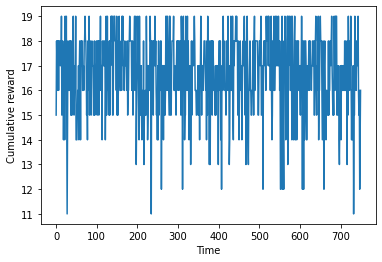

Final reward: -16.0


In [13]:
args = {"environment_name": 'MVC',
        "agent": 'Agent',
        "graph_type": 'erdos_renyi',
        "graph_nbr": 100,
        "model": 'S2V',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MAXCUT: erdos_renyi

MAXCUT with the degree distribution erdos_renyi by the model S2V
Epoch: 0
Game number: 1
    Cumulative rewards = 10.0
    Optimal solution = 21.0
    Cumulative rewards = 12.0
    Optimal solution = 21.0
    Cumulative rewards = 17.0
    Optimal solution = 21.0
    Cumulative rewards = 0.0
    Optimal solution = 21.0
    Cumulative rewards = 8.0
    Optimal solution = 21.0
Game number: 2
    Cumulative rewards = 9.0
    Optimal solution = 23.0
    Cumulative rewards = 6.0
    Optimal solution = 23.0
    Cumulative rewards = 9.0
    Optimal solution = 23.0
    Cumulative rewards = 1.0
    Optimal solution = 23.0
    Cumulative rewards = 4.0
    Optimal solution = 23.0
Game number: 3
    Cumulative rewards = 7.0
    Optimal solution = 22.0
    Cumulative rewards = 8.0
    Optimal solution = 22.0
    Cumulative rewards = 5.0
    Optimal solution = 22.0
    Cumulative rewards = 16.0
    Optimal solution = 22.0
    Cumulative rewards = 12.0
    Optimal solution = 22.0
Game number: 4
    Cu

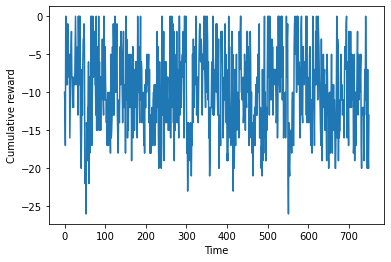

Final reward: 13.0


In [14]:
args = {"environment_name": 'MAXCUT',
        "agent": 'Agent',
        "graph_type": 'erdos_renyi',
        "graph_nbr": 100,
        "model": 'S2V',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MVC: powerlaw

MVC with the degree distribution powerlaw by the model S2V
Epoch: 0
Game number: 1
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -17.0
    Optimal solution = 12.0
    Cumulative rewards = -19.0
    Optimal solution = 12.0
    Cumulative rewards = -17.0
    Optimal solution = 12.0
    Cumulative rewards = -18.0
    Optimal solution = 12.0
Game number: 2
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -16.0
    Optimal solution = 12.0
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -17.0
    Optimal solution = 12.0
    Cumulative rewards = -19.0
    Optimal solution = 12.0
Game number: 3
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -16.0
    Optimal solution = 12.0
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -16.0
    Optimal solution = 12.0
    Cumulative rewards = -17.0
    Optimal solution = 12.0
Ga

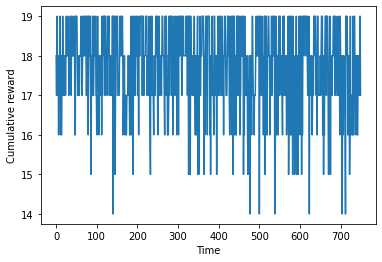

Final reward: -17.0


In [15]:
args = {"environment_name": 'MVC',
        "agent": 'Agent',
        "graph_type": 'powerlaw',
        "graph_nbr": 100,
        "model": 'S2V',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MAXCUT: powerlaw

MAXCUT with the degree distribution powerlaw by the model S2V
Epoch: 0
Game number: 1
    Cumulative rewards = 36.0
    Optimal solution = 45.0
    Cumulative rewards = 37.0
    Optimal solution = 45.0
    Cumulative rewards = 34.0
    Optimal solution = 45.0
    Cumulative rewards = 34.0
    Optimal solution = 45.0
    Cumulative rewards = 36.0
    Optimal solution = 45.0
Game number: 2
    Cumulative rewards = 30.0
    Optimal solution = 45.0
    Cumulative rewards = 31.0
    Optimal solution = 45.0
    Cumulative rewards = 32.0
    Optimal solution = 45.0
    Cumulative rewards = 33.0
    Optimal solution = 45.0
    Cumulative rewards = 35.0
    Optimal solution = 45.0
Game number: 3
    Cumulative rewards = 19.0
    Optimal solution = 47.0
    Cumulative rewards = 33.0
    Optimal solution = 47.0
    Cumulative rewards = 34.0
    Optimal solution = 47.0
    Cumulative rewards = 36.0
    Optimal solution = 47.0
    Cumulative rewards = 34.0
    Optimal solution = 47.0
Game number: 4

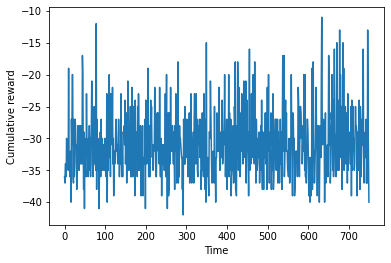

Final reward: 40.0


In [16]:
args = {"environment_name": 'MAXCUT',
        "agent": 'Agent',
        "graph_type": 'powerlaw',
        "graph_nbr": 100,
        "model": 'S2V',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MVC: barabasi_albert

MVC with the degree distribution barabasi_albert by the model S2V
Epoch: 0
Game number: 1
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -17.0
    Optimal solution = 12.0
    Cumulative rewards = -19.0
    Optimal solution = 12.0
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -18.0
    Optimal solution = 12.0
Game number: 2
    Cumulative rewards = -18.0
    Optimal solution = 11.0
    Cumulative rewards = -17.0
    Optimal solution = 11.0
    Cumulative rewards = -17.0
    Optimal solution = 11.0
    Cumulative rewards = -15.0
    Optimal solution = 11.0
    Cumulative rewards = -19.0
    Optimal solution = 11.0
Game number: 3
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -19.0
    Optimal solution = 12.0
    Cumulative rewards = -16.0
    Optimal solution = 12.0
    Cumulative rewards = -19.0
    Optimal solution = 12.0
    Cumulative rewards = -17.0
    Optimal solution = 

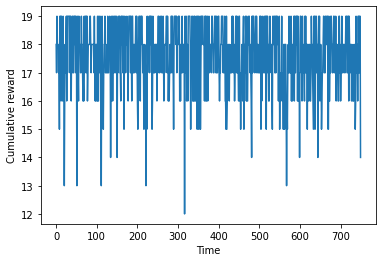

Final reward: -14.0


In [17]:
args = {"environment_name": 'MVC',
        "agent": 'Agent',
        "graph_type": 'barabasi_albert',
        "graph_nbr": 100,
        "model": 'S2V',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MAXCUT: barabasi_albert

MAXCUT with the degree distribution barabasi_albert by the model S2V
Epoch: 0
Game number: 1
    Cumulative rewards = 30.0
    Optimal solution = 47.0
    Cumulative rewards = 28.0
    Optimal solution = 47.0
    Cumulative rewards = 31.0
    Optimal solution = 47.0
    Cumulative rewards = 35.0
    Optimal solution = 47.0
    Cumulative rewards = 32.0
    Optimal solution = 47.0
Game number: 2
    Cumulative rewards = 33.0
    Optimal solution = 47.0
    Cumulative rewards = 27.0
    Optimal solution = 47.0
    Cumulative rewards = 33.0
    Optimal solution = 47.0
    Cumulative rewards = 26.0
    Optimal solution = 47.0
    Cumulative rewards = 29.0
    Optimal solution = 47.0
Game number: 3
    Cumulative rewards = 29.0
    Optimal solution = 47.0
    Cumulative rewards = 26.0
    Optimal solution = 47.0
    Cumulative rewards = 20.0
    Optimal solution = 47.0
    Cumulative rewards = 27.0
    Optimal solution = 47.0
    Cumulative rewards = 32.0
    Optimal solution = 47.0
Game nu

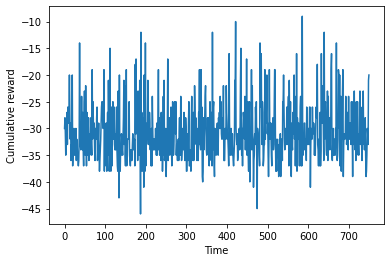

Final reward: 20.0


In [18]:
args = {"environment_name": 'MAXCUT',
        "agent": 'Agent',
        "graph_type": 'barabasi_albert',
        "graph_nbr": 100,
        "model": 'S2V',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MVC: gnp_random_graph

MVC with the degree distribution gnp_random_graph by the model S2V
Epoch: 0
Game number: 1
    Cumulative rewards = -16.0
    Optimal solution = 7.0
    Cumulative rewards = -16.0
    Optimal solution = 7.0
    Cumulative rewards = -14.0
    Optimal solution = 7.0
    Cumulative rewards = -15.0
    Optimal solution = 7.0
    Cumulative rewards = -18.0
    Optimal solution = 7.0
Game number: 2
    Cumulative rewards = -19.0
    Optimal solution = 9.0
    Cumulative rewards = -16.0
    Optimal solution = 9.0
    Cumulative rewards = -18.0
    Optimal solution = 9.0
    Cumulative rewards = -14.0
    Optimal solution = 9.0
    Cumulative rewards = -16.0
    Optimal solution = 9.0
Game number: 3
    Cumulative rewards = -17.0
    Optimal solution = 11.0
    Cumulative rewards = -18.0
    Optimal solution = 11.0
    Cumulative rewards = -17.0
    Optimal solution = 11.0
    Cumulative rewards = -16.0
    Optimal solution = 11.0
    Cumulative rewards = -17.0
    Optimal solution = 11.0
Game

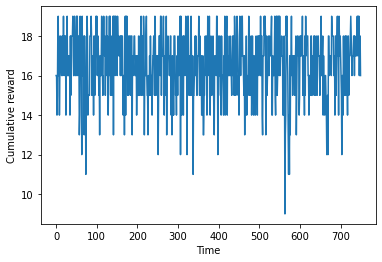

Final reward: -16.0


In [19]:
args = {"environment_name": 'MVC',
        "agent": 'Agent',
        "graph_type": 'gnp_random_graph',
        "graph_nbr": 100,
        "model": 'S2V',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MAXCUT: gnp_random_graph

MAXCUT with the degree distribution gnp_random_graph by the model S2V
Epoch: 0
Game number: 1
    Cumulative rewards = 11.0
    Optimal solution = 24.0
    Cumulative rewards = 5.0
    Optimal solution = 24.0
    Cumulative rewards = 7.0
    Optimal solution = 24.0
    Cumulative rewards = 13.0
    Optimal solution = 24.0
    Cumulative rewards = 17.0
    Optimal solution = 24.0
Game number: 2
    Cumulative rewards = 6.0
    Optimal solution = 23.0
    Cumulative rewards = 17.0
    Optimal solution = 23.0
    Cumulative rewards = 8.0
    Optimal solution = 23.0
    Cumulative rewards = 19.0
    Optimal solution = 23.0
    Cumulative rewards = 12.0
    Optimal solution = 23.0
Game number: 3
    Cumulative rewards = 10.0
    Optimal solution = 26.0
    Cumulative rewards = 17.0
    Optimal solution = 26.0
    Cumulative rewards = 15.0
    Optimal solution = 26.0
    Cumulative rewards = 11.0
    Optimal solution = 26.0
    Cumulative rewards = 17.0
    Optimal solution = 26.0
Game numbe

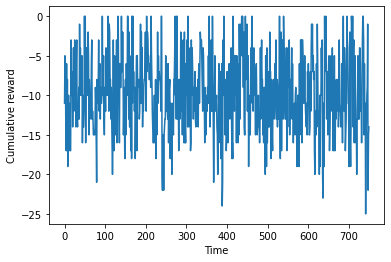

Final reward: 14.0


In [20]:
args = {"environment_name": 'MAXCUT',
        "agent": 'Agent',
        "graph_type": 'gnp_random_graph',
        "graph_nbr": 100,
        "model": 'S2V',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

### Graph Convolutional Network Algortihm

MVC: erdos_renyi

MVC with the degree distribution erdos_renyi by the model GCN
Epoch: 0
Game number: 1
    Cumulative rewards = -19.0
    Optimal solution = 10.0
    Cumulative rewards = -16.0
    Optimal solution = 10.0
    Cumulative rewards = -15.0
    Optimal solution = 10.0
    Cumulative rewards = -18.0
    Optimal solution = 10.0
    Cumulative rewards = -15.0
    Optimal solution = 10.0
Game number: 2
    Cumulative rewards = -16.0
    Optimal solution = 8.0
    Cumulative rewards = -15.0
    Optimal solution = 8.0
    Cumulative rewards = -17.0
    Optimal solution = 8.0
    Cumulative rewards = -19.0
    Optimal solution = 8.0
    Cumulative rewards = -18.0
    Optimal solution = 8.0
Game number: 3
    Cumulative rewards = -18.0
    Optimal solution = 10.0
    Cumulative rewards = -16.0
    Optimal solution = 10.0
    Cumulative rewards = -17.0
    Optimal solution = 10.0
    Cumulative rewards = -15.0
    Optimal solution = 10.0
    Cumulative rewards = -16.0
    Optimal solution = 10.0
Game

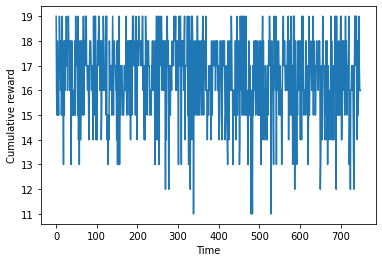

Final reward: -16.0


In [21]:
args = {"environment_name": 'MVC',
        "agent": 'Agent',
        "graph_type": 'erdos_renyi',
        "graph_nbr": 100,
        "model": 'GCN',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MAXCUT: erdos_renyi

MAXCUT with the degree distribution erdos_renyi by the model GCN
Epoch: 0
Game number: 1
    Cumulative rewards = 14.0
    Optimal solution = 21.0
    Cumulative rewards = 5.0
    Optimal solution = 21.0
    Cumulative rewards = 5.0
    Optimal solution = 21.0
    Cumulative rewards = 13.0
    Optimal solution = 21.0
    Cumulative rewards = 13.0
    Optimal solution = 21.0
Game number: 2
    Cumulative rewards = 19.0
    Optimal solution = 24.0
    Cumulative rewards = 0.0
    Optimal solution = 24.0
    Cumulative rewards = 9.0
    Optimal solution = 24.0
    Cumulative rewards = 5.0
    Optimal solution = 24.0
    Cumulative rewards = 11.0
    Optimal solution = 24.0
Game number: 3
    Cumulative rewards = 16.0
    Optimal solution = 23.0
    Cumulative rewards = 12.0
    Optimal solution = 23.0
    Cumulative rewards = 7.0
    Optimal solution = 23.0
    Cumulative rewards = 15.0
    Optimal solution = 23.0
    Cumulative rewards = 10.0
    Optimal solution = 23.0
Game number: 4
  

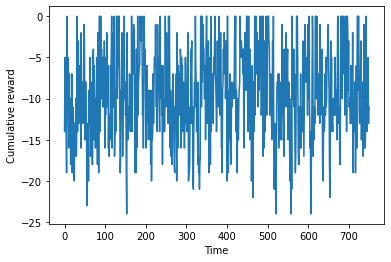

Final reward: 11.0


In [22]:
args = {"environment_name": 'MAXCUT',
        "agent": 'Agent',
        "graph_type": 'erdos_renyi',
        "graph_nbr": 100,
        "model": 'GCN',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MVC: powerlaw

MVC with the degree distribution powerlaw by the model GCN
Epoch: 0
Game number: 1
    Cumulative rewards = -17.0
    Optimal solution = 11.0
    Cumulative rewards = -19.0
    Optimal solution = 11.0
    Cumulative rewards = -19.0
    Optimal solution = 11.0
    Cumulative rewards = -17.0
    Optimal solution = 11.0
    Cumulative rewards = -17.0
    Optimal solution = 11.0
Game number: 2
    Cumulative rewards = -18.0
    Optimal solution = 11.0
    Cumulative rewards = -18.0
    Optimal solution = 11.0
    Cumulative rewards = -19.0
    Optimal solution = 11.0
    Cumulative rewards = -19.0
    Optimal solution = 11.0
    Cumulative rewards = -17.0
    Optimal solution = 11.0
Game number: 3
    Cumulative rewards = -19.0
    Optimal solution = 12.0
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -16.0
    Optimal solution = 12.0
Ga

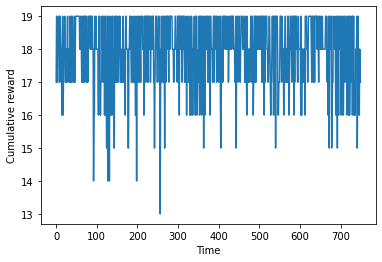

Final reward: -17.0


In [23]:
args = {"environment_name": 'MVC',
        "agent": 'Agent',
        "graph_type": 'powerlaw',
        "graph_nbr": 100,
        "model": 'GCN',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MAXCUT: powerlaw

MAXCUT with the degree distribution powerlaw by the model GCN
Epoch: 0
Game number: 1
    Cumulative rewards = 35.0
    Optimal solution = 47.0
    Cumulative rewards = 35.0
    Optimal solution = 47.0
    Cumulative rewards = 25.0
    Optimal solution = 47.0
    Cumulative rewards = 32.0
    Optimal solution = 47.0
    Cumulative rewards = 40.0
    Optimal solution = 47.0
Game number: 2
    Cumulative rewards = 31.0
    Optimal solution = 46.0
    Cumulative rewards = 26.0
    Optimal solution = 46.0
    Cumulative rewards = 32.0
    Optimal solution = 46.0
    Cumulative rewards = 36.0
    Optimal solution = 46.0
    Cumulative rewards = 32.0
    Optimal solution = 46.0
Game number: 3
    Cumulative rewards = 32.0
    Optimal solution = 45.0
    Cumulative rewards = 22.0
    Optimal solution = 45.0
    Cumulative rewards = 34.0
    Optimal solution = 45.0
    Cumulative rewards = 26.0
    Optimal solution = 45.0
    Cumulative rewards = 32.0
    Optimal solution = 45.0
Game number: 4

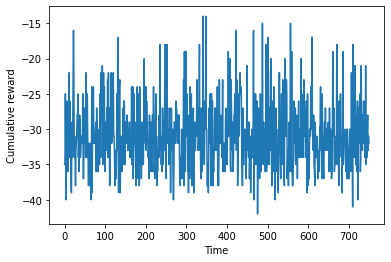

Final reward: 32.0


In [24]:
args = {"environment_name": 'MAXCUT',
        "agent": 'Agent',
        "graph_type": 'powerlaw',
        "graph_nbr": 100,
        "model": 'GCN',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MVC: barabasi_albert

MVC with the degree distribution barabasi_albert by the model GCN
Epoch: 0
Game number: 1
    Cumulative rewards = -19.0
    Optimal solution = 12.0
    Cumulative rewards = -13.0
    Optimal solution = 12.0
    Cumulative rewards = -16.0
    Optimal solution = 12.0
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -19.0
    Optimal solution = 12.0
Game number: 2
    Cumulative rewards = -19.0
    Optimal solution = 12.0
    Cumulative rewards = -18.0
    Optimal solution = 12.0
    Cumulative rewards = -16.0
    Optimal solution = 12.0
    Cumulative rewards = -17.0
    Optimal solution = 12.0
    Cumulative rewards = -19.0
    Optimal solution = 12.0
Game number: 3
    Cumulative rewards = -17.0
    Optimal solution = 13.0
    Cumulative rewards = -16.0
    Optimal solution = 13.0
    Cumulative rewards = -17.0
    Optimal solution = 13.0
    Cumulative rewards = -18.0
    Optimal solution = 13.0
    Cumulative rewards = -18.0
    Optimal solution = 

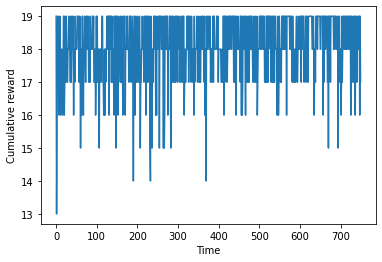

Final reward: -17.0


In [25]:
args = {"environment_name": 'MVC',
        "agent": 'Agent',
        "graph_type": 'barabasi_albert',
        "graph_nbr": 100,
        "model": 'GCN',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MAXCUT: barabasi_albert

MAXCUT with the degree distribution barabasi_albert by the model GCN
Epoch: 0
Game number: 1
    Cumulative rewards = 12.0
    Optimal solution = 49.0
    Cumulative rewards = 32.0
    Optimal solution = 49.0
    Cumulative rewards = 40.0
    Optimal solution = 49.0
    Cumulative rewards = 31.0
    Optimal solution = 49.0
    Cumulative rewards = 18.0
    Optimal solution = 49.0
Game number: 2
    Cumulative rewards = 32.0
    Optimal solution = 45.0
    Cumulative rewards = 32.0
    Optimal solution = 45.0
    Cumulative rewards = 26.0
    Optimal solution = 45.0
    Cumulative rewards = 22.0
    Optimal solution = 45.0
    Cumulative rewards = 40.0
    Optimal solution = 45.0
Game number: 3
    Cumulative rewards = 25.0
    Optimal solution = 46.0
    Cumulative rewards = 38.0
    Optimal solution = 46.0
    Cumulative rewards = 29.0
    Optimal solution = 46.0
    Cumulative rewards = 36.0
    Optimal solution = 46.0
    Cumulative rewards = 34.0
    Optimal solution = 46.0
Game nu

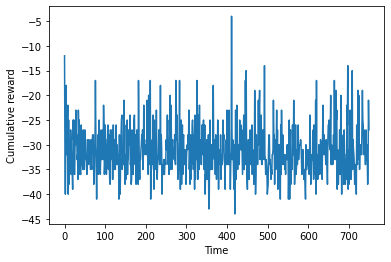

Final reward: 27.0


In [26]:
args = {"environment_name": 'MAXCUT',
        "agent": 'Agent',
        "graph_type": 'barabasi_albert',
        "graph_nbr": 100,
        "model": 'GCN',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MVC: gnp_random_graph

MVC with the degree distribution gnp_random_graph by the model GCN
Epoch: 0
Game number: 1
    Cumulative rewards = -19.0
    Optimal solution = 8.0
    Cumulative rewards = -18.0
    Optimal solution = 8.0
    Cumulative rewards = -18.0
    Optimal solution = 8.0
    Cumulative rewards = -16.0
    Optimal solution = 8.0
    Cumulative rewards = -17.0
    Optimal solution = 8.0
Game number: 2
    Cumulative rewards = -16.0
    Optimal solution = 10.0
    Cumulative rewards = -17.0
    Optimal solution = 10.0
    Cumulative rewards = -15.0
    Optimal solution = 10.0
    Cumulative rewards = -15.0
    Optimal solution = 10.0
    Cumulative rewards = -18.0
    Optimal solution = 10.0
Game number: 3
    Cumulative rewards = -15.0
    Optimal solution = 9.0
    Cumulative rewards = -16.0
    Optimal solution = 9.0
    Cumulative rewards = -18.0
    Optimal solution = 9.0
    Cumulative rewards = -16.0
    Optimal solution = 9.0
    Cumulative rewards = -17.0
    Optimal solution = 9.0
Game

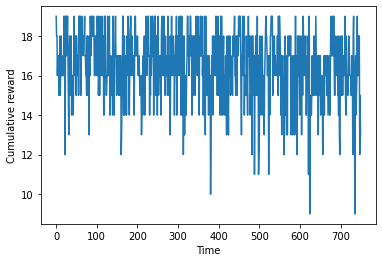

Final reward: -13.0


In [27]:
args = {"environment_name": 'MVC',
        "agent": 'Agent',
        "graph_type": 'gnp_random_graph',
        "graph_nbr": 100,
        "model": 'GCN',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)

MAXCUT: gnp_random_graph

MAXCUT with the degree distribution gnp_random_graph by the model GCN
Epoch: 0
Game number: 1
    Cumulative rewards = 13.0
    Optimal solution = 25.0
    Cumulative rewards = 16.0
    Optimal solution = 25.0
    Cumulative rewards = 9.0
    Optimal solution = 25.0
    Cumulative rewards = 15.0
    Optimal solution = 25.0
    Cumulative rewards = 12.0
    Optimal solution = 25.0
Game number: 2
    Cumulative rewards = 4.0
    Optimal solution = 22.0
    Cumulative rewards = 0.0
    Optimal solution = 22.0
    Cumulative rewards = 4.0
    Optimal solution = 22.0
    Cumulative rewards = 8.0
    Optimal solution = 22.0
    Cumulative rewards = 7.0
    Optimal solution = 22.0
Game number: 3
    Cumulative rewards = 12.0
    Optimal solution = 30.0
    Cumulative rewards = 17.0
    Optimal solution = 30.0
    Cumulative rewards = 19.0
    Optimal solution = 30.0
    Cumulative rewards = 15.0
    Optimal solution = 30.0
    Cumulative rewards = 7.0
    Optimal solution = 30.0
Game number: 

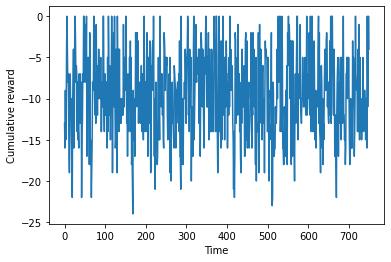

Final reward: 4.0


In [28]:
args = {"environment_name": 'MAXCUT',
        "agent": 'Agent',
        "graph_type": 'gnp_random_graph',
        "graph_nbr": 100,
        "model": 'GCN',
        "ngames": 50,
        "niter": 100,
        "epoch": 3,
        "lr": 1e-4,
        "bs": 32,
        "n_step": 3,
        "node": 20,
        "p": 0.14,
        "m": 4,
        "verbose": True
        }

main(args)